In [1]:
import numpy as np
import pandas as pd
import random
from matplotlib import pyplot as plt
random.seed(99)

# Defining States Dictionary

Non-Terminal states are defined as a dictionary with the state name as key and right and left states as values to generate the sequence data

In [2]:
states = {
           "B":{"right":"C","left":"A"}
          ,"C":{"right":"D","left":"B"}
          ,"D":{"right":"E","left":"C"}
          ,"E":{"right":"F","left":"D"}
          ,"F":{"right":"G","left":"A"}
         }
states_list = list(states.keys())
terminal_state = ["A","G"]

# Training Data Generation

A training data of 100 sets each with 10 sequences is generated. Each sequence starts with state "D" and ends in the terminal state of either "A" or "G". Each non terminal state has a probability of 0.5 to move to either left or right state.

In [3]:
training_data = []
for i in range(100):
    training_set = []
    for i in range(10):
        Terminal = False
        state = "D"
        sequence =["D"]
        while not Terminal:
            new_state = states[state]["right"] if random.random() > 0.5 else states[state]["left"]
            if new_state in terminal_state:
                sequence.append(new_state)
                Terminal = True
            else:
                sequence.append(new_state)
                state = new_state   
        training_set.append(sequence)
    training_data.append(training_set)

# True Probability

The true probabilities of right-side termination the ideal predictions is given as 1/6,2/6,3/6,4/6,5/6 for states B, C, D, E and F, respectively.

In [4]:
true_prob = np.array([1/6,2/6,3/6,4/6,5/6])

# Delta Weights
Below is the utility function to calculate delta weight for each sequence using equation 4 in http://incompleteideas.net/papers/sutton-88-with-erratum.pdf . The function is used in the experiments.

In [5]:
def calulate_sequence_delta_weights(sequence,weights,lmbda,learning_rate):
    eligibility_trace = np.zeros(5)
    sequence_delta_weights = np.zeros(5)
    for state_pos,_ in enumerate(sequence):
        current_state = sequence[state_pos]   
        if current_state not in terminal_state:
            next_state = sequence[state_pos + 1]
            # In our random walk example gradient will be just X_t which is nothing but the unit vecto generated below
            gradient = np.array([int(i == states_list.index(current_state)) for i in range(5)])
            eligibility_trace = (lmbda * eligibility_trace) + gradient
            # p_t is w*x_t where x_t is a unit vector. Since it is implemented as a list, instead of unit vecor direct index is used
            p_t = weights[states_list.index(current_state)]     
            # p_t is w*x_t_plus_1 where x_t_plus_1 is a unit vector. Since it is implemented as a list, instead of unit vecor direct index is used
            p_t_plus_1 = weights[states_list.index(next_state)]  if next_state not in terminal_state else 1 if next_state == "G" else 0
            state_delta_weight = learning_rate * (p_t_plus_1 - p_t) * eligibility_trace
            sequence_delta_weights += state_delta_weight
    return sequence_delta_weights

# Repeated presentation

In Repeated Presentation, TD(Lambda) is run on each training set repeatedly until it converges. The weight is updated with accumulated delta over all the sequences in the training set.

In [6]:
def TD_lambda_repeated_presentation(training_data,lmbda,learning_rate):
    rmse = 0
    for training_set in training_data:
        weights = np.array([0.5,0.5,0.5,0.5,0.5])
        continue_until_convergence = True
        while continue_until_convergence:             
            cumulative_delta_weights = np.zeros(5)
            for sequence in training_set:
                sequence_delta_weights = calulate_sequence_delta_weights(sequence,weights,lmbda,learning_rate)
                cumulative_delta_weights = cumulative_delta_weights + sequence_delta_weights
            previous_weights = weights
            weights = weights+cumulative_delta_weights
            weights_diff = np.linalg.norm(previous_weights-weights)
            continue_until_convergence = False if weights_diff < 0.0001 else True
        rmse += np.sqrt(np.mean((weights-true_prob)**2))
    return rmse

# Single Presentation

In Single Presentation, TD(Lambda) is run by presenting training set only once. The weight is update after each sequence. 

In [7]:
def TD_lambda_single_presentation(training_data,lmbda,learning_rate):
    rmse = 0
    for training_set in training_data:
        weights = np.array([0.5,0.5,0.5,0.5,0.5])
        for sequence in training_set:
            sequence_delta_weights = calulate_sequence_delta_weights(sequence,weights,lmbda,learning_rate)
            weights = weights+ sequence_delta_weights
        rmse += np.sqrt(np.mean((weights-true_prob)**2))
    return rmse

# Experiment 1 

Repeated Presentation TD(lambda) is exectued for lambda values of 0 to 1 with increment of 0.1

In [8]:
experiment_1_lambdas = [0,0.1,0.3,0.5,0.7,0.9,1]
experiment_1_rmse = []
learning_rate = 0.01
for _,lmbda in enumerate(experiment_1_lambdas):
    rmse = TD_lambda_repeated_presentation(training_data,lmbda,learning_rate)
    experiment_1_rmse.append(rmse)

### Sutton Figure 3

Based on Experiment 1, Error is plotted for each Lambda

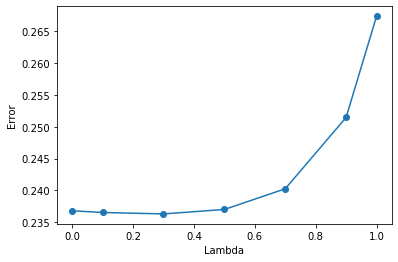

In [9]:
experiment_1_avg_rmse = [i/100 for i in experiment_1_rmse]
repeated_df = pd.DataFrame({"Lambda":experiment_1_lambdas,"RMSE":experiment_1_avg_rmse})
plt.plot(repeated_df["Lambda"],repeated_df["RMSE"],marker="o")
plt.xlabel("Lambda")
plt.ylabel("Error")
plt.savefig("repeated.png")

# Experiment 2 - Multiple Learning Rates

Single Presentation TD(lambda) is executed for the lambda's 0,0.3,0.8 and 1 with multiple alpha values from 0 to 0.6.

In [10]:
experiment_2_1_alphas = list(np.arange(0,0.6,0.05))
experiment_2_1_lambdas = [0,0.3,0.8,1]
experiment_2_1_rmse = []
for _,lmbda in enumerate(experiment_2_1_lambdas):
    lambda_rmse = []
    for _,alpha in enumerate(experiment_2_1_alphas):
        rmse = TD_lambda_single_presentation(training_data,lmbda,alpha)
        lambda_rmse.append(rmse)
    experiment_2_1_rmse.append(lambda_rmse)

### Sutton Figure 4

Based on Experiment 2, Error is plotted for each Lambda(0,0.3,0.8,1) against different alpha values

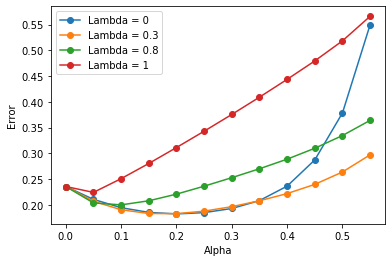

In [11]:
experiment_2_1_avg_rmse = [[i/100 for i in j] for j in experiment_2_1_rmse]
all_alpha_df = pd.DataFrame({"Alpha":experiment_2_1_alphas
                           ,"L_0_RMSE":experiment_2_1_avg_rmse[0]
                          ,"L_03_RMSE":experiment_2_1_avg_rmse[1]
                          ,"L_08_RMSE":experiment_2_1_avg_rmse[2]
                          ,"L_1_RMSE":experiment_2_1_avg_rmse[3]})
plt.plot(all_alpha_df["Alpha"],all_alpha_df["L_0_RMSE"],marker="o",label="Lambda = 0")
plt.plot(all_alpha_df["Alpha"],all_alpha_df["L_03_RMSE"],marker="o",label="Lambda = 0.3")
plt.plot(all_alpha_df["Alpha"],all_alpha_df["L_08_RMSE"],marker="o",label="Lambda = 0.8")
plt.plot(all_alpha_df["Alpha"],all_alpha_df["L_1_RMSE"],marker="o",label="Lambda = 1")
plt.legend()
plt.xlabel("Alpha")
plt.ylabel("Error")
plt.savefig("all_alpha.png")

# Experiment 2 - Best Learning Rate

This experiment is just repeatation of Experiment 2 for different lambda values from 0 to 1 with more granular alpha values between 0 and 0.5 to pick the best alpha value for each lambda

In [12]:
experiment_2_2_alphas = list(np.arange(0,0.5,0.01))
experiment_2_2_lambdas = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
experiment_2_2_rmse = []
for _,lmbda in enumerate(experiment_2_2_lambdas):
    lambda_rmse = []
    for _,alpha in enumerate(experiment_2_2_alphas):
        rmse = TD_lambda_single_presentation(training_data,lmbda,alpha)
        lambda_rmse.append(rmse)
    experiment_2_2_rmse.append(lambda_rmse)

### Sutton Figure 5

Minimum Error(with Best Alpha) is plotted for each Lambda value

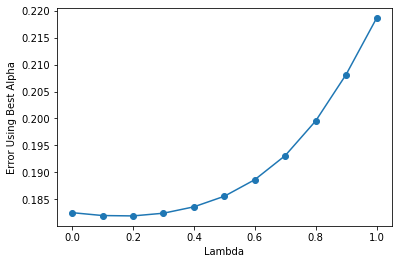

In [13]:
experiment_2_2_min_rmse = [min(x) for x in experiment_2_2_rmse]
experiment_2_2_avg_rmse = [i/100 for i in experiment_2_2_min_rmse]


best_alpha_df = pd.DataFrame({"Lambda":experiment_2_2_lambdas
                           ,"MIN_RMSE":experiment_2_2_avg_rmse})
plt.plot(best_alpha_df["Lambda"],best_alpha_df["MIN_RMSE"],marker="o")
plt.xlabel("Lambda")
plt.ylabel("Error Using Best Alpha")
plt.savefig("best_alpha.png")